In [1]:
import numpy as np
import h5py
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
import os
%matplotlib inline

In [2]:
ct_data, pet_data, label_data = [], [], []
num_data = 2
with h5py.File(os.path.join('..','input','lab_petct_vox_5.00mm.h5'),'r') as p_data:
    for ct_img, pet_img, label in zip(p_data['ct_data'].values(),
                                      p_data['pet_data'].values(),
                                      p_data['label_data'].values()):
        ct_data += [np.array(ct_img)]
        pet_data += [np.array(pet_img)]
        label_data += [np.array(label)]
        num_data = num_data - 1
        if num_data == 0:
            break

In [3]:
ct_cubes, pet_cubes,lab_cubes = [], [], []
tile_size=16
stride=3
for ct_img, pet_img, label in zip(ct_data, pet_data, label_data):
    for i in range(0,  ct_img.shape[0], tile_size):
        for j in range(0,  ct_img.shape[1], tile_size):
            for z in range(0,  ct_img.shape[2], tile_size):
                for i_k in range(0, tile_size, stride):
                    for j_k in range(0, tile_size, stride):
                        for z_k in range(0,tile_size,stride):
                            ct_cubes += [ct_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            pet_cubes += [pet_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            lab_cubes += [label[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]] 

In [4]:
# The following functions take a cube and an axis and return a projection of the tile along the axis
def reduceCTCube(cube,axis):
    return np.sum(cube,axis)
    
def reducePETCube(cube,axis):
    return(np.sqrt(np.max(pt_img,axis)))
    
def reduceLabelCube(cube):
    # write here, returns a single value, not a list/array    
    return(np.mean(cube))
        
        
    
    

In [5]:
data_tiles, data_labels = [], []

n_ct_cubes = [c_tile for c_tile in ct_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_pet_cubes = [c_tile for c_tile in pet_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_lab_cubes = [c_tile for c_tile in lab_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]


for ct_cube, pet_cube, lab_cube in zip(n_ct_cubes, n_pet_cubes,n_lab_cubes):
    data_tile = []
    for axis in range(3):
        data_tile = np.concatenate([data_tile, reduceCTCube(ct_cube, axis).flatten()])
                
    data_tiles += [data_tile]
    data_labels += [reduceLabelCube(lab_cube)]
    

In [114]:
print(data_labels)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [8]:
lab_class = [c_score > 0 for c_score in data_labels]
from sklearn.model_selection import train_test_split
train_tiles, test_tile, train_score, test_score = train_test_split(data_tiles, data_labels, 
                                                                   train_size = 0.8, stratify = lab_class, random_state = 1234)
#print('Training size', train_tiles.shape, 'Testing size', test_tile.shape)
print('Train tumor tiles', np.where(train_score), 'Test tumor tiles', np.where(test_score))

Train tumor tiles (array([  183,   239,   367, ..., 98141, 98259, 98278], dtype=int64),) Test tumor tiles (array([   21,    59,   118,   147,   149,   192,   358,   432,   435,
         470,   506,   525,   598,   603,   604,   753,   989,  1006,
        1067,  1168,  1532,  1566,  1594,  1640,  1806,  1807,  1812,
        1858,  1860,  2027,  2064,  2206,  2333,  2336,  2357,  2399,
        2447,  2526,  2616,  2692,  2907,  2934,  3181,  3233,  3268,
        3331,  3349,  3423,  3785,  3803,  3806,  3810,  3947,  4197,
        4287,  4342,  4491,  4518,  4809,  4906,  4948,  4992,  5175,
        5180,  5260,  5274,  5300,  5547,  5641,  5644,  5659,  5700,
        5746,  5968,  6038,  6103,  6351,  6450,  6523,  6533,  6543,
        6567,  6686,  6720,  6804,  6834,  6933,  6948,  6981,  7023,
        7036,  7341,  7354,  7407,  7425,  7587,  7591,  7766,  7785,
        7930,  7995,  8017,  8128,  8169,  8218,  8533,  8693,  8970,
        9006,  9022,  9059,  9224,  9262,  9303,  936

In [9]:
from sklearn.linear_model import LinearRegression
knn1_model =LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=5)



In [10]:
train_tiles[3].shape

(768,)

In [11]:
knn1_model.fit(train_tiles, train_score)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [13]:
test_predictions = knn1_model.predict(test_tile)
print('Predicted Results', test_predictions)

Predicted Results [ 0.  0.  0. ...,  0.  0.  0.]


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(test_score)>0, np.array(test_predictions)>0)

array([[24168,    89],
       [   14,   305]])

(-0.1, 1.1)

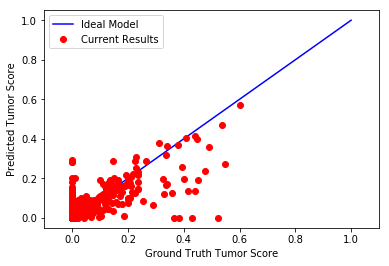

In [15]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Ideal Model')
ax1.plot(test_score, test_predictions, 'ro', label = 'Current Results')
ax1.set_xlabel('Ground Truth Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)